In [2]:
VideoFileName = "TheSEOPlaybook"
AudioFileName = "TheSEOPlaybook"

In [5]:
#Convert Video to audio
import subprocess
videoname= AudioFileName+".mp4"
audioname =AudioFileName+".wav"
subprocess.call(('ffmpeg -y -i "%s" "%s"')%(videoname, audioname),shell=True)\

In [6]:
#crop audio
subprocess.call("ffmpeg -ss 0 -t 300 -i Neilpatelshow.mp4 Neilpatelshow1.mp4")

In [ ]:
#Perform Diarization
import subprocess
subprocess.call(('java -Xmx500m -jar ./LIUM_SpkDiarization-8.4.1.jar \
--fInputMask=./"%s".wav \
--sOutputMask=./"%s".seg \
--doCEClustering Speaker \
--system=current \
--cMaximumMerge=4 \
--cMinimumOfCluster=2 \
--doTuning=2 --doCEClustering')%(AudioFileName, AudioFileName),shell=True) 

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


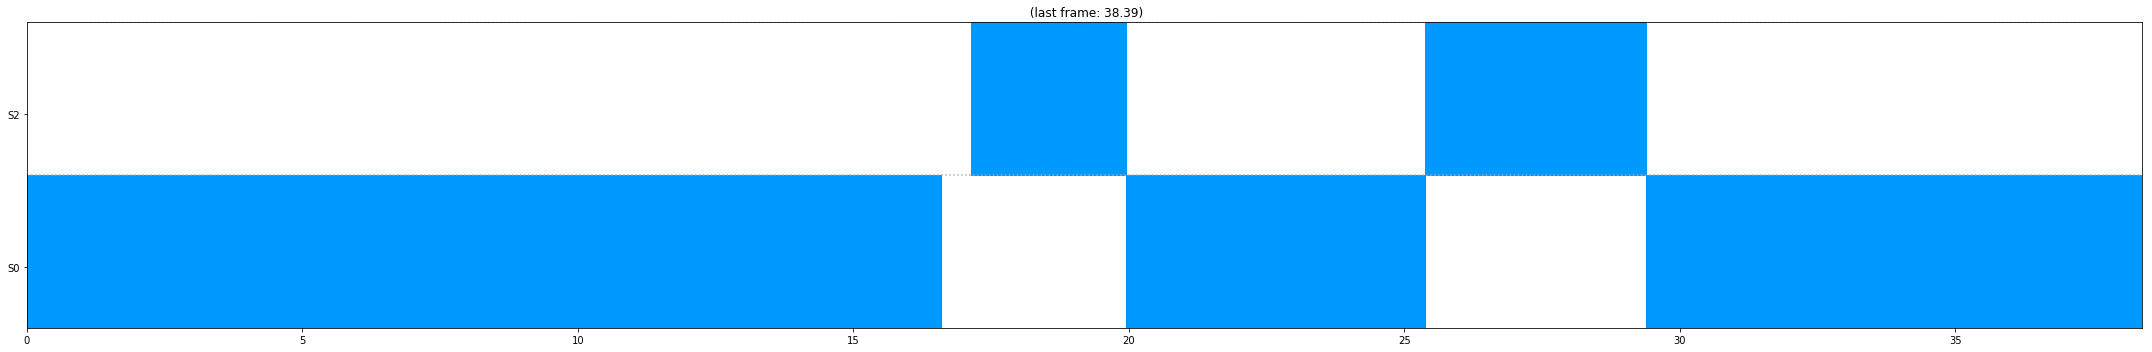

In [3]:
%matplotlib inline
from s4d.diar import Diar
import os
ref = Diar.read_seg(os.path.join(AudioFileName + '.mfcc'))


import matplotlib
import matplotlib.pyplot as plot
from matplotlib.patches import Rectangle

class PlotDiar:
    """
    A viewer of segmentation
    """
    def __init__(self, seg, wav=None, title='', gui=False, pick=False, vgrid=False, size=(18, 9)):
        self.rect_picked = None
        self.rect_color = (0.0, 0.6, 1.0, 1.0)  # '#0099FF'
        self.rect_selected_color = (0.75, 0.75, 0, 1.0)  # 'y'

        plot.rcParams['keymap.fullscreen'] = 'ctrl+f'
        plot.rcParams['keymap.home'] = ''
        plot.rcParams['keymap.back'] = ''
        plot.rcParams['keymap.forward'] = ''
        plot.rcParams['keymap.pan'] = ''
        plot.rcParams['keymap.zoom'] = 'ctrl+z'
        plot.rcParams['keymap.quit'] = 'ctrl+q'
        plot.rcParams['keymap.grid'] = ''
        plot.rcParams['keymap.yscale'] = ''
        plot.rcParams['keymap.xscale'] = ''
        plot.rcParams['keymap.all_axes'] = ''
        plot.rcParams['toolbar'] = 'None'
        plot.rcParams['keymap.save'] = 'ctrl+s'
        # plot.rcParams.update({'font.family': 'courrier'})

        self.pick = pick
        self.gui = gui
        self.vgrid = vgrid
        self.fig = plot.figure(figsize=size, facecolor='white', tight_layout=True)
        self.title = title

        self.ax = self.fig.add_subplot(1, 1, 1)
        cids = list()
        if self.gui:
            cids.append(
                self.fig.canvas.mpl_connect('key_press_event', self._on_keypress))
            cids.append(
                self.fig.canvas.mpl_connect('button_press_event', self._on_click))
            if pick:
                cids.append(self.fig.canvas.mpl_connect('pick_event', self._on_pick))
        self.height = 5
        self.maxx = 0
        self.maxy = 0
        self.end_play = 0
        self.seg = seg
        self.wav = wav
        self.audio = None
        if self.wav is not None and self.gui:
            self.audio = AudioPlayer(wav)
            self.timer = self.fig.canvas.new_timer(interval=10)
            self.timer.add_callback(self._update_timeline)
            self.timer.start()

        self.timeline = self.ax.plot([0, 0], [0, 0], color='r')[-1]
        self.map = self.seg.make_index(['show', 'cluster'])
        self.time_stamp = list()
        self.time_stamp_idx = 0

    def _draw_timeline(self, t):
        """
        Draw the timeline a position t
        :param t: in second, a float

        """
        min, max = self.ax.get_ylim()
        self.timeline.set_data([t, t], [min, max])
        self._draw_info(t)

    def _update_timeline(self):
        """
        Update the timeline given the position in the audio player

        """
        if self.audio is not None and self.audio.playing():
            t = self.audio.time()
            min, max = self.ax.get_xlim()
            if t > self.end_play and self.rect_picked is not None:
                self.audio.pause()
                self.end_play = self.maxx
            self._draw_timeline(t)
            if t > max:
                self._dec_right(min, max)
            if t < min:
                self._dec_left(min, max)
            self.fig.canvas.draw()

    def _draw_info(self, t):
        """
        Draw information on segment and timestamp
        :param t: a float
        :return:
        """
        ch = 'time:{:s} ({:.3f} sec {:d} frame)'.format(self._hms(t), t,
                                                        int(t * 100))
        ch2 = '\n\n\n'
        if self.rect_picked is not None:
            s = self.rect_picked.get_x()
            w = self.rect_picked.get_width()
            e = s + w
            ch2 = 'segment  start: {:20s} ({:8.2f} sec {:8d} frame)\n'.format(
                self._hms(s), s, int(s * 100))
            ch2 += 'segment   stop: {:20s} ({:8.2f} sec {:8d} frame)\n'.format(
                self._hms(e), e, int(e * 100))
            ch2 += 'segment lenght: {:20s} ({:8.2f} sec {:8d} frame)\n'.format(
                self._hms(w), w, int(w * 100))

        plot.xlabel(ch + '\n' + ch2)

    def draw(self):
        """
        Draw the segmentation

        """
        y = 0
        labels_pos = []
        labels = []
        for show in self.map:
            for cluster in sorted(self.map[show].keys()):
                labels.append(cluster)
                labels_pos.append(y + self.height // 2)
                for row in self.map[show][cluster]:
                    x = row['start'] / 100
                    self.time_stamp.append(x)
                    self.time_stamp.append(row['stop'] / 100)
                    w = row.duration() / 100
                    self.maxx = max(self.maxx, row['stop'] / 100)
                    c = self.rect_color
                    if row._attributes.exist('color'):
                        c = row['color']
                    rect = plot.Rectangle((x, y), w, self.height,
                                          color=c, picker=self.pick)
                    self.ax.add_patch(rect)
                y += self.height
        if self.gui:
            plot.xlim([0, min(600, self.maxx)])
        else:
            plot.xlim([0, self.maxx])

        plot.ylim([0, y])
        plot.yticks(labels_pos, labels)
        self.maxy = y
        self.end_play = self.maxx
        for show in self.map:
            for cluster in self.map[show]:
                self.ax.plot([0, self.maxx], [y, y], linestyle=':',
                             color='#AAAAAA')
                y -= self.height

        plot.title(self.title + ' (last frame: ' + str(self.maxx) + ')')
        if self.gui:
            self._draw_info(0)
        plot.tight_layout()
        self.time_stamp = list(set(self.time_stamp))
        self.time_stamp.sort()

        if self.vgrid:
            for x in  self.time_stamp:
                self.ax.plot([x, x], [0, self.maxy], linestyle=':',
                             color='#AAAAAA')


    def _dec_right(self, min, max):
        """
        Move right
        :param min: a float
        :param max: a float

        """
        dec = (max - min) // 10
        diff = max - min
        if max + dec <= self.maxx:
            print('** 1 ', min, max, dec)
            plot.xlim(min + dec, max + dec)
        else:
            print('** 2 ', min, max, dec, diff)
            plot.xlim(self.maxx - diff, self.maxx)

    def _dec_left(self, min, max):
        """
        Move left
        :param min: a float
        :param max: a float

        """
        dec = (max - min) // 10
        diff = max - min
        if min - dec >= 0:
            plot.xlim(min - dec, max - dec)
        else:
            plot.xlim(0, diff)

    def _on_keypress(self, event):
        """
        manage the keypress event
        :param event: a key event

        """
        hmin, hmax = self.ax.get_xlim()
        diff = hmax - hmin
        if event.key == 'ctrl++' or event.key == 'ctrl+=':
            plot.xlim(hmin * 1.5, hmax * 1.5)
        elif event.key == 'ctrl+-':
            plot.xlim(hmin / 1.5, hmax / 1.5)
        elif event.key == 'escape':
            plot.xlim(0, self.maxx)
            plot.ylim(0, self.maxy)
        elif event.key == 'right':
            self._dec_right(hmin, hmax)
        elif event.key == 'left':
            self._dec_left(hmin, hmax)
        elif event.key == 'ctrl+right':
            plot.xlim(self.maxx - diff, self.maxx)
        elif event.key == 'ctrl+left':
            plot.xlim(0, diff)
        elif event.key == 'alt+right':
            self.time_stamp_idx = min(len(self.time_stamp)-1, self.time_stamp_idx + 1)
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(self.time_stamp[self.time_stamp_idx])
            self._draw_timeline(self.time_stamp[self.time_stamp_idx])
        elif event.key == 'alt+left':
            self.time_stamp_idx = max(0, self.time_stamp_idx - 1)
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(self.time_stamp[self.time_stamp_idx])
            self._draw_timeline(self.time_stamp[self.time_stamp_idx])
        elif event.key is None and self.audio is not None:
            self.audio.play()
        elif event.key == ' ' and self.audio is not None:
            self.audio.pause()

        self.fig.canvas.draw()

    def _on_click(self, event):
        """
        manage the mouse event
        :param event: a mouse event

        """
        if event.xdata is not None and self.rect_picked is None:
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(event.xdata)
            self._draw_timeline(event.xdata)
            self.fig.canvas.draw()

    def _on_pick(self, event):
        """
        manage the selection of a segment
        :param event: a picked event

        """
        if isinstance(event.artist, Rectangle) and event.mouseevent.dblclick:
            print('on pick dbclick')
            rect = event.artist
            x, y = rect.get_xy()
            w = rect.get_width()
            c = rect.get_fc()
            if self.rect_picked is not None:
                if self._colors_are_equal(c, self.rect_selected_color):
                    rect.set_color(self.rect_color)
                    self.rect_picked = None
                    self.end_play = self.maxx
                else:
                    self.rect_picked.set_color(self.rect_color)
                    rect.set_color(self.rect_selected_color)
                    self.rect_picked = rect
                    if self.audio is not None:
                        self.audio.pause()
                        self.audio.seek(x)
                    self.time_stamp_idx = self.time_stamp.index(x)
                    self.end_play = x + w
                    self._draw_timeline(x)
            else:
                rect.set_color(self.rect_selected_color)
                self.rect_picked = rect

                if self.audio is not None:
                    self.audio.pause()
                    self.audio.seek(x)
                self.time_stamp_idx = self.time_stamp.index(x)
                self.end_play = x + w
                self._draw_timeline(x)

            self.fig.canvas.draw()

    @classmethod
    def _colors_are_equal(cls, c1, c2):
        """
        Compare two colors
        """
        for i in range(4):
            if c1[i] != c2[i]:
                return False
        return True

    @classmethod
    def _hms(cls, s):
        """
        conversion of seconds into hours, minutes and secondes
        :param s:
        :return: int, int, float
        """
        h = int(s) // 3600
        s %= 3600
        m = int(s) // 60
        s %= 60
        return '{:d}:{:d}:{:.2f}'.format(h, m, s)

#Draw Plot    
p = PlotDiar(ref, size=(30, 5))
p.draw()

In [32]:
import pandas as pd
df = pd.DataFrame(columns=['Speaker','tmp','start','end','gender','channel','environment'])

import re
fic = open(AudioFileName + '.seg', 'r', encoding="utf8")
for line in fic:
        line = re.sub('\s+',' ',line)
        line = line.strip()
        # logging.debug(line)
        if line.startswith('#') or line.startswith(';;'):
            continue
        # split line into fields
        show, tmp, start, length, gender, channel, environment, name = line.split()
        starttime = int(start)/100
        endtime = (int(start) +int(length))/100
        df = df.append({'Speaker':name,'tmp':tmp,'start':starttime,'end':endtime, \
                        'gender':gender,'channel':channel,'environment':environment}, ignore_index=True)
        
dfnew=df.sort_values('start').reset_index().drop(['index'],axis=1)

import wave
import contextlib
fname = AudioFileName+".wav"
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
duration
cc=dfnew.groupby('Speaker').count()

import subprocess
import os
for j in range(len(cc.index)):
    mergedaudioname = AudioFileName + cc.index[j] 
    p = ""
    for i in range(len(dfnew)):
        if dfnew['Speaker'][i] == cc.index[j]:
            audioclip = AudioFileName+ "_" + dfnew['Speaker'][i]+ "_" + str(i) +".wav"
            subprocess.call(("""ffmpeg -y -i %s.wav -af "volume=enable='between(t,0,%s)':volume=0, volume=enable='between(t,%s,%s)':volume=0" %s""")%(AudioFileName, dfnew['start'][i], dfnew['end'][i], duration, audioclip),shell =True)
            s="-i" +" " + audioclip
            p=p+s
            pp= p.replace('-i', ' -i')
            if (cc['tmp'][j] != 1):
                subprocess.call(('ffmpeg%s -filter_complex amix=inputs=%s:duration=longest:dropout_transition=0 -y %s.wav')%(pp, cc['tmp'][j],  mergedaudioname), shell =True)
            else:
                os.rename(audioclip, mergedaudioname+".wav") 
#Remove intermediate files
for i in range(len(dfnew)):
    audioclip = AudioFileName+ "_" + dfnew['Speaker'][i]+ "_" + str(i) +".wav"
    try:
        os.remove(audioclip)
    except:
        print("file not found")

In [2]:
AudioFileName = "TheSEOPlaybook"

import subprocess
subprocess.call(('java -Xmx500m -jar ./LIUM_SpkDiarization-8.4.1.jar \
fr.lium.spkDiarization.tools.Wave2FeatureSet \
--fInputMask=./"%s".wav \
--sInputMask="" \
--fInputDesc="audio16kHz2sphinx,1:1:0:0:0:0,13,0:0:0" \
--sOutputMask=./"%s".mfcc \
--fOutputDesc="audio16kHz2sphinx,1:1:0:0:0:0,13,0:0:0"')%(AudioFileName, AudioFileName),shell=True) 

0